In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline

In [34]:
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(filepath_or_buffer='reviews.tsv', sep='\t', names=['Class', 'Review'])
df

,Class,Review
0,0,unless bob crane is someone of particular inte...
1,1,"finds a way to tell a simple story , perhaps t..."
2,0,"ill-considered , unholy hokum ."
3,0,"nijinsky says , 'i know how to suffer' and if ..."
4,1,the auteur's ear for the way fears and slights...
...,...,...
10657,0,"it's mildly sentimental , unabashedly consumer..."
10658,0,so verbally flatfooted and so emotionally pred...
10659,0,alternative medicine obviously has its merits ...
10660,0,a by-the-numbers patient/doctor pic that cover...


In [3]:
from sklearn.model_selection import train_test_split

y, x = df.Class, df.Review

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfild_vectorizer(n_gram):
    vectorizer = TfidfVectorizer(
        lowercase=True, stop_words=None,
        use_idf=True, ngram_range=n_gram,
        smooth_idf=False
    )
    tv_train_vector = vectorizer.fit_transform(x_train)
    tv_test_vector = vectorizer.transform(x_test)
    return tv_train_vector, tv_test_vector

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def bin_count_vectorizer(n_gram):
    count_vectorizer = CountVectorizer(
        analyzer="word", ngram_range=n_gram,
        stop_words=None, lowercase=True,
        binary=True, strip_accents=None
    )
    bin_train_vectors = count_vectorizer.fit_transform(x_train)
    bin_test_vectors = count_vectorizer.transform(x_test)
    return bin_train_vectors, bin_test_vectors

In [6]:
# K-ближайших соседей ( 𝑛=5 )
def knn_cv_n(neighbor, n_gram):
    
    tv_train_vector, tv_test_vector = tfild_vectorizer(n_gram)
    
    knn_cv = KNeighborsClassifier(n_neighbors=neighbor).fit(tv_train_vector, y_train)
    y_knn_cv = knn_cv.predict(tv_test_vector)

    time_knn_model = %timeit -qo  knn_cv.fit(tv_train_vector, y_train)
    time_knn_model_pred = %timeit -qo  knn_cv.predict(tv_test_vector)
    
    k_rez = classification_report(y_test, y_knn_cv)
    k_rez_dict = classification_report(y_test, y_knn_cv, output_dict=True)
    
    return time_knn_model, time_knn_model_pred, k_rez, k_rez_dict

In [7]:
# Логистическая регрессия ( 𝐶=1 )
def logreg_model_c(c, n_gram):
    
    tv_train_vector, tv_test_vector = tfild_vectorizer(n_gram)
    
    logreg_model = LogisticRegression(
        penalty="l2", fit_intercept=True,
        max_iter=100, C=c,
        solver="lbfgs", random_state=12345
    ).fit(tv_train_vector, y_train)

    y_logreg_model = logreg_model.predict(tv_test_vector)

    time_logreg_model = %timeit -qo  logreg_model.fit(tv_train_vector, y_train)
    time_logreg_model_pred = %timeit -qo  logreg_model.predict(tv_test_vector)

    log_rez = classification_report(y_test, y_logreg_model)
    log_rez_dict = classification_report(y_test, y_logreg_model, output_dict=True)
    
    return time_logreg_model, time_logreg_model_pred, log_rez, log_rez_dict

In [8]:
# Наивный Байес: модель Бернулли ( 𝛼=1 )
def m_bernNB_a(alphas, n_gram):
    bin_train_vectors, bin_test_vectors = bin_count_vectorizer(n_gram)
    
    m_bernNB = BernoulliNB(alpha=alphas, binarize=None).fit(bin_train_vectors, y_train)
    y_m_bernNB = m_bernNB.predict(bin_test_vectors)

    time_m_bernNB = %timeit -qo  m_bernNB.fit(bin_train_vectors, y_train)
    time_m_bernNB_pred = %timeit -qo  m_bernNB.predict(bin_test_vectors)
    
    nb_rez = classification_report(y_test, y_m_bernNB)
    nb_rez_dict = classification_report(y_test, y_m_bernNB, output_dict=True)
    
    return time_m_bernNB, time_m_bernNB_pred, nb_rez, nb_rez_dict

In [9]:
# Наивный Байес: полиномиальная модель ( 𝛼=1 )
def m_bern_multi_NB_a(alphas, n_gram):
    tv_train_vector, tv_test_vector = tfild_vectorizer(n_gram)
    
    m_bern_multi_NB = MultinomialNB(alpha=alphas).fit(tv_train_vector, y_train)
    y_m_bern_multi_NB = m_bern_multi_NB.predict(tv_test_vector)

    time_m_bern_multi_NB = %timeit -qo  m_bern_multi_NB.fit(tv_train_vector, y_train)
    time_m_bern_multi_NB_pred = %timeit -qo  m_bern_multi_NB.predict(tv_test_vector)
    
    
    nb_mult_rez = classification_report(y_test, y_m_bern_multi_NB)
    nb_mult_rez_dict = classification_report(y_test, y_m_bern_multi_NB, output_dict=True)
    
    return time_m_bern_multi_NB, time_m_bern_multi_NB_pred, nb_mult_rez, nb_mult_rez_dict

In [10]:
time_knn_model, time_knn_model, rez, rez_dict = knn_cv_n(neighbor=5, n_gram=(1,1))
print('K-ближайших соседей\n')
print(f"Time = {time_knn_model.average}s\n")
print(rez)

time_logreg_model, time_logreg_model_pred, log_rez, log_rez_dict = logreg_model_c(c=1, n_gram=(1,1))
print('Логистическая регрессия\n')
print(f"Time = {time_logreg_model.average}s\n")
print(log_rez)

time_m_bernNB, time_m_bernNB_pred, nb_rez, nb_rez_dict = m_bernNB_a(alphas=1, n_gram=(1,1))
print('Наивный Байес: модель Бернулли\n')
print(f"Time = {time_m_bernNB.average}s\n")
print(nb_rez)

time_m_bern_multi_NB, time_m_bern_multi_NB_pred, nb_mult_rez, nb_mult_rez_dict = m_bern_multi_NB_a(alphas=1, n_gram=(1,1))
print('Наивный Байес: полиномиальная модель\n')
print(f"Time = {time_m_bern_multi_NB.average}s\n")
print(nb_mult_rez)

K-ближайших соседей

Time = 1.0361595408571398s

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1065
           1       0.72      0.75      0.73      1068

    accuracy                           0.73      2133
   macro avg       0.73      0.73      0.73      2133
weighted avg       0.73      0.73      0.73      2133

Логистическая регрессия

Time = 0.11555618215714226s

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1065
           1       0.76      0.79      0.78      1068

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133

Наивный Байес: модель Бернулли

Time = 0.0028673968757143243s

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1065
           1       0.79      0.77      0.78      1068

    accuracy    

In [11]:
columns_name = [
    'Model',
    'Class',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-score',
    'Time',
]
df_rez = pd.DataFrame(columns = columns_name)
index = 0 

In [12]:
def df_create(classification, name_model, time):
    global columns_name, df_rez, index
    accur = classification['accuracy']
    for keys, values in classification.items():
        if keys in ['macro avg', 'weighted avg', 'accuracy']:
            continue
        else:
            df_rez.loc[index] = [
                name_model, 
                keys,
                accur,
                values['precision'],
                values['recall'],
                values['f1-score'],
                time,
            ]
            index += 1

In [13]:
def add_df_create(list_dict, list_name, list_time):
    for d, n, t in zip(list_dict, list_name, list_time):
        df_create(d, n, t)

In [14]:
add_df_create(
    [
        rez_dict,
        log_rez_dict,
        nb_rez_dict,
        nb_mult_rez_dict
    ],
    [
        'K-ближайших соседей',
        'Логистическая регрессия',
        'Наивный Байес: модель Бернулли',
        'Наивный Байес: полиномиальная модель'
    ],
    [
        time_knn_model.average,
        time_logreg_model.average,
        time_m_bernNB.average,
        time_m_bern_multi_NB.average
    ]
)

In [15]:
df_rez

,Model,Class,Accuracy,Precision,Recall,F1-score,Time
0,K-ближайших соседей,0,0.725738,0.734834,0.705164,0.719693,1.036160
1,K-ближайших соседей,1,0.725738,0.717372,0.746255,0.731528,1.036160
2,Логистическая регрессия,0,0.769808,0.781925,0.747418,0.764282,0.115556
3,Логистическая регрессия,1,0.769808,0.758744,0.792135,0.775080,0.115556
4,Наивный Байес: модель Бернулли,0,0.782466,0.777470,0.790610,0.783985,0.002867
5,Наивный Байес: модель Бернулли,1,0.782466,0.787619,0.774345,0.780925,0.002867
6,Наивный Байес: полиномиальная модель,0,0.784341,0.782446,0.786854,0.784644,0.002681
7,Наивный Байес: полиномиальная модель,1,0.784341,0.786252,0.781835,0.784038,0.002681


In [16]:
kf = KFold(n_splits=4, shuffle=True, random_state=123)

In [17]:
#K-ближайших соседей (n=5)
def k_tarin(n, n_gram):
    return Pipeline([
        ("vectorizer", TfidfVectorizer(
        lowercase=True, stop_words=None,
        use_idf=True, ngram_range=n_gram,
        smooth_idf=False)
        ), 
        ("classifier", KNeighborsClassifier(n_neighbors=n))
    ])


y_k_train = cross_validate(
    k_tarin(5, (1,1)),
    x,
    y, 
    cv=kf,
    return_train_score=True,
    scoring=['accuracy', 'recall', 'precision', 'f1']
)

In [18]:
#Логистическая регрессия с=1
def c_train(c, n_gram):
    return Pipeline([
        ("vectorizer", TfidfVectorizer(
            lowercase=True, stop_words=None,
            use_idf=True, ngram_range=n_gram,
            smooth_idf=False)
        ),  
        ("classifier", LogisticRegression(
            penalty="l2", fit_intercept=True,
            max_iter=100, C=c,
            solver="lbfgs", random_state=12345)
        )
    ])

y_logic_train = cross_validate(
    c_train(1, (1, 1)),
    x,
    y, 
    cv=kf,
    return_train_score=True,
    scoring=['accuracy', 'recall', 'precision', 'f1']
)

In [19]:
#Наивный Байес: модель Бернулли
def bernl_train(alphas, n_gram):
    return Pipeline([
        ("vectorizer", CountVectorizer(analyzer="word", ngram_range=n_gram,
                                       stop_words=None, lowercase=True,
                                       binary=True, strip_accents=None)), 
        ("classifier", BernoulliNB(alpha=alphas, binarize=None))
    ])

y_bernl = cross_validate(
    bernl_train(1, (1,1)),
    x,
    y, 
    cv=kf,
    return_train_score=True,
    scoring=['accuracy', 'recall', 'precision', 'f1']
)

In [20]:
#Наивный Байес: полиномиальная модель
def polynomial_model(alphas, n_gram):
    return Pipeline([
        ("vectorizer", CountVectorizer(analyzer="word", ngram_range=n_gram,
                                       stop_words=None, lowercase=True,
                                       binary=True, strip_accents=None)), 
        ("classifier", MultinomialNB(alpha=alphas))
    ])

y_bernl_mult = cross_validate(
    polynomial_model(1, (1,1)),
    x,
    y, 
    cv=kf,
    return_train_score=True,
    scoring=['accuracy', 'recall', 'precision', 'f1']
)

In [21]:
#create dataframe
columns_name_add = [
    'Model',
    'Fit_time',
    'Score_time',
    'Test_accuracy',
    'Train_accuracy',
    'Test_recall',
    'Train_recall',
    'Test_precision',
    'Train_precision',
    'Test_f1',
    'Train_f1',
]
df_rez_add = pd.DataFrame(columns = columns_name_add)
index_add = 0 

In [22]:
def df_create(classification, name_model):
    global columns_name_add, df_rez_add, index_add
    df_rez_add.loc[index_add] = [
            name_model, 
            classification['fit_time'].mean(),
            classification['score_time'].mean(),
            classification['test_accuracy'].mean(),
            classification['train_accuracy'].mean(),
            classification['test_recall'].mean(),
            classification['train_recall'].mean(),
            classification['test_precision'].mean(),
            classification['train_precision'].mean(),
            classification['test_f1'].mean(),
            classification['train_f1'].mean(),
        ]
    index_add += 1

In [23]:
def add_df_create(list_dict, list_name):
    for d, n in zip(list_dict, list_name):
        df_create(d, n)

In [24]:
add_df_create(
    [
        y_k_train,
        y_logic_train,
        y_bernl,
        y_bernl_mult
    ],
    [
        'K-ближайших соседей',
        'Логистическая регрессия',
        'Наивный Байес: модель Бернулли',
        'Наивный Байес: полиномиальная модель'
    ]
)

In [25]:
df_rez_add

,Model,Fit_time,Score_time,Test_accuracy,Train_accuracy,Test_recall,Train_recall,Test_precision,Train_precision,Test_f1,Train_f1
0,K-ближайших соседей,0.159983,0.937207,0.705027,0.824986,0.717357,0.832421,0.700227,0.820226,0.708624,0.826271
1,Логистическая регрессия,0.318564,0.054504,0.759800,0.899425,0.769307,0.890639,0.754997,0.906571,0.762054,0.898534
2,Наивный Байес: модель Бернулли,0.165066,0.053731,0.775278,0.932877,0.762660,0.918016,0.782394,0.946175,0.772390,0.931863
3,Наивный Байес: полиномиальная модель,0.186101,0.057374,0.775746,0.934127,0.764711,0.921269,0.781921,0.945617,0.773210,0.933267


In [26]:
columns_name_rez = [
    'Model',
    'Class',
    'N_gram',
    'Model_param',
    'Time_train',
    'Time_prediction',
    'Accuracy',
    'Recall',
    'Precision',
    'F1',
]
df_model = pd.DataFrame(columns = columns_name_rez)
index_rez = 0 

In [27]:
def df_rez_model(rez_dict, name_model, n_gram, best_train, time, time_pred):
    global columns_name_rez, df_model, index_rez
    accur = rez_dict['accuracy']
    for key, val in rez_dict.items():
        if key in ['macro avg', 'weighted avg', 'accuracy']:
            continue
        else:
            df_model.loc[index_rez] = [
                name_model,
                key,
                n_gram,
                best_train,
                time.average,
                time_pred.average,
                accur,
                val['recall'],
                val['precision'],
                val['f1-score']
        ]
        index_rez += 1
    

In [28]:
#K-ближайших соседей
def k_neighbors(n_gram):
    ns = np.arange(1, 150, 20)  # количество соседей
    list_mean = []
    for i in ns:
        y_k_train = cross_validate(
            k_tarin(i, n_gram),
            x_train,
            y_train, 
            cv=kf,
            return_train_score=True,
            scoring=['accuracy', 'recall', 'precision', 'f1']
    )
        list_mean.append([y_k_train['test_accuracy'].mean(), i, y_k_train['train_accuracy'].mean()]) 
        
        
    best_y_k_train = max(list_mean, key=lambda x: x[0])[1]
    #print(list_mean)
    #print(best_y_k_train)
    time, time_pred, rez, rez_dict = knn_cv_n(best_y_k_train, n_gram)

    print(f"Time = {time.average}s\n")
    print(rez)
    
    plt.plot(ns, [i[2] for i in list_mean], label='Train Accuracy')
    plt.plot(ns, [i[0] for i in list_mean], label='Test Accuracy')
    plt.title(f'n_gram {n_gram}, best {best_y_k_train}')
    plt.xlabel('количество соседей')
    plt.ylabel('доля правильных классификаций')
    plt.legend()
    plt.show()
    
    df_rez_model(rez_dict, 'K-ближайших соседей', n_gram, best_y_k_train, time, time_pred)
    
    
    return time.average, rez
    

In [29]:
#Логистическая регрессия
def logistic_regression(n_gram):
    cs = np.logspace(-2, 10, 8, base=10)  # параметр регуляризации
    list_mean = []
    for i in cs:
        y_logic_train = cross_validate(
            c_train(i, n_gram),
            x_train,
            y_train, 
            cv=kf,
            return_train_score=True,
            scoring=['accuracy', 'recall', 'precision', 'f1']
        )
        list_mean.append([y_logic_train['test_accuracy'].mean(), i, y_logic_train['train_accuracy'].mean()]) 
        
        
    best_y_logic_train = max(list_mean, key=lambda x: x[0])[1]
    #print(list_mean)
    #print(best_y_logic_train)
    time, time_pred, rez, rez_dict = logreg_model_c(best_y_logic_train, n_gram)

    print(f"Time = {time.average}s\n")
    print(rez)
    
    plt.plot(cs, [i[2] for i in list_mean], label='Train Accuracy')
    plt.plot(cs, [i[0] for i in list_mean], label='Test Accuracy')
    plt.title(f'n_gram {n_gram}, best {best_y_logic_train}')
    plt.xlabel('параметр регуляризации')
    plt.ylabel('доля правильных классификаций')
    plt.legend()
    plt.show()
    
    df_rez_model(rez_dict, 'Логистическая регрессия', n_gram, best_y_logic_train, time, time_pred)
    
    
    return time.average, rez

In [30]:
#Наивный Байес: модель Бернулли
def model_bernulli(n_gram):
    alphas = np.logspace(-4, 1, 8, base=10)  # сглаживающий параметр
    list_mean = []
    for alpha in alphas:
        y_bernl = cross_validate(
            bernl_train(alpha, n_gram),
            x_train,
            y_train, 
            cv=kf,
            return_train_score=True,
            scoring=['accuracy', 'recall', 'precision', 'f1']
        )
        list_mean.append([y_bernl['test_accuracy'].mean(), alpha, y_bernl['train_accuracy'].mean()]) 
        
        
    best_y_bernl = max(list_mean, key=lambda x: x[0])[1]
    #print(list_mean)
    #print(best_y_bernl)
    time, time_pred, rez, rez_dic = m_bernNB_a(best_y_bernl, n_gram)

    print(f"Time = {time.average}s\n")
    print(rez)
    
    plt.plot(alphas, [i[2] for i in list_mean], label='Train Accuracy')
    plt.plot(alphas, [i[0] for i in list_mean], label='Test Accuracy')
    plt.title(f'n_gram {n_gram}, best {best_y_bernl}')
    plt.xlabel('сглаживающий параметр')
    plt.ylabel('доля правильных классификаций')
    plt.legend()
    plt.show()
    
    df_rez_model(rez_dict, 'Наивный Байес: модель Бернулли', n_gram, best_y_bernl, time, time_pred)
    
    
    return time.average, rez
    

In [31]:
#Наивный Байес: полиномиальная модель
def model_polynomial(n_gram):
    alphas = np.logspace(-4, 1, 8, base=10)  # сглаживающий параметр
    list_mean = []
    for alpha in alphas:
        y_bernl_mult = cross_validate(
            polynomial_model(alpha, n_gram),
            x,
            y, 
            cv=kf,
            return_train_score=True,
            scoring=['accuracy', 'recall', 'precision', 'f1']
        )
        list_mean.append([y_bernl_mult['test_accuracy'].mean(), alpha, y_bernl_mult['train_accuracy'].mean()]) 
        
        
    best_y_bernl_mult = max(list_mean, key=lambda x: x[0])[1]
    #print(list_mean)
    #print(best_y_bernl)
    time, time_pred, rez, rez_dic = m_bern_multi_NB_a(best_y_bernl_mult, n_gram)

    print(f"Time = {time.average}s\n")
    print(rez)
    
    plt.plot(alphas, [i[2] for i in list_mean], label='Train Accuracy')
    plt.plot(alphas, [i[0] for i in list_mean], label='Test Accuracy')
    plt.title(f'n_gram {n_gram}, best {best_y_bernl_mult}')
    plt.xlabel('сглаживающий параметр')
    plt.ylabel('доля правильных классификаций')
    plt.legend()
    plt.show()
    
    df_rez_model(rez_dict, 'Наивный Байес: полиномиальная модель', n_gram, best_y_bernl_mult, time, time_pred)

################################

 K-ближайших соседей 

Time = 0.0008261451857142917s

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1065
           1       0.74      0.79      0.77      1068

    accuracy                           0.76      2133
   macro avg       0.76      0.76      0.76      2133
weighted avg       0.76      0.76      0.76      2133



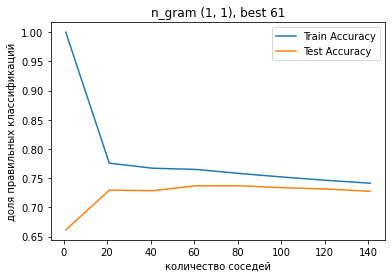

################################

 Логистическая регрессия 

Time = 0.2774531830000017s

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1065
           1       0.77      0.77      0.77      1068

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133



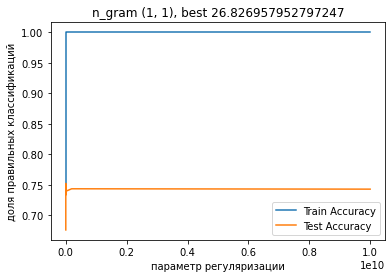

################################

 Наивный Байес: модель Бернулли 

Time = 0.0020660172285714195s

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1065
           1       0.79      0.78      0.78      1068

    accuracy                           0.78      2133
   macro avg       0.78      0.78      0.78      2133
weighted avg       0.78      0.78      0.78      2133



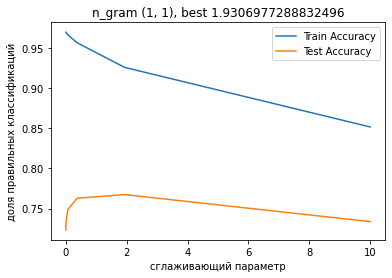

################################

 Наивный Байес: полиномиальная модель 

Time = 0.0023638102657143434s

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1065
           1       0.79      0.79      0.79      1068

    accuracy                           0.79      2133
   macro avg       0.79      0.79      0.79      2133
weighted avg       0.79      0.79      0.79      2133



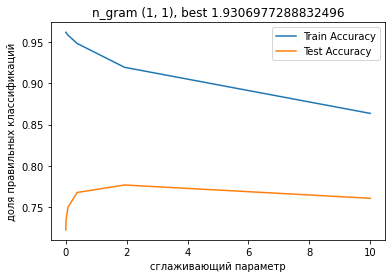

################################

 K-ближайших соседей 

Time = 0.000840922176571423s

              precision    recall  f1-score   support

           0       0.61      0.87      0.72      1065
           1       0.78      0.45      0.57      1068

    accuracy                           0.66      2133
   macro avg       0.69      0.66      0.64      2133
weighted avg       0.69      0.66      0.64      2133



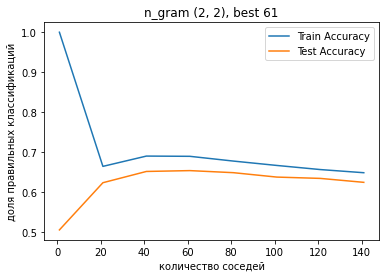

################################

 Логистическая регрессия 

Time = 0.32210565342856107s

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1065
           1       0.70      0.71      0.71      1068

    accuracy                           0.70      2133
   macro avg       0.70      0.70      0.70      2133
weighted avg       0.70      0.70      0.70      2133



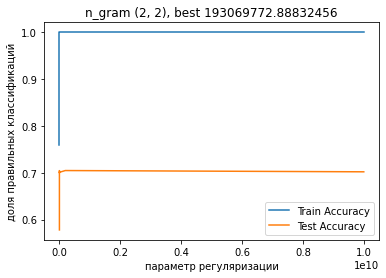

################################

 Наивный Байес: модель Бернулли 

Time = 0.004165240721428225s

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1065
           1       0.72      0.72      0.72      1068

    accuracy                           0.72      2133
   macro avg       0.72      0.72      0.72      2133
weighted avg       0.72      0.72      0.72      2133



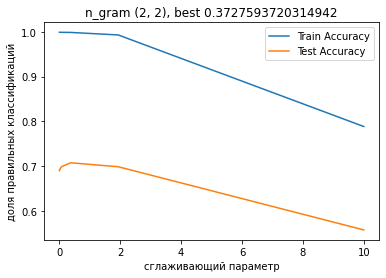

################################

 Наивный Байес: полиномиальная модель 

Time = 0.00394176038285715s

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1065
           1       0.73      0.73      0.73      1068

    accuracy                           0.73      2133
   macro avg       0.73      0.73      0.73      2133
weighted avg       0.73      0.73      0.73      2133



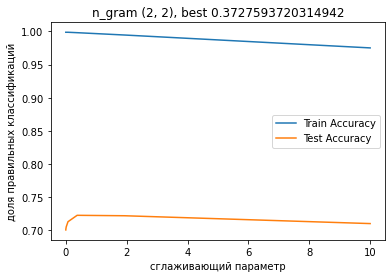

################################

 K-ближайших соседей 

Time = 0.0011395134827142945s

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1065
           1       0.76      0.77      0.77      1068

    accuracy                           0.76      2133
   macro avg       0.76      0.76      0.76      2133
weighted avg       0.76      0.76      0.76      2133



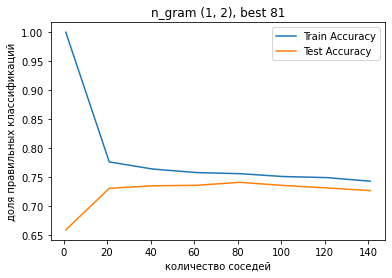

################################

 Логистическая регрессия 

Time = 2.2144279894285677s

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1065
           1       0.78      0.83      0.80      1068

    accuracy                           0.80      2133
   macro avg       0.80      0.80      0.80      2133
weighted avg       0.80      0.80      0.80      2133



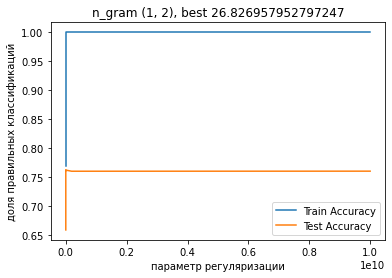

################################

 Наивный Байес: модель Бернулли 

Time = 0.0056332319128572245s

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1065
           1       0.78      0.78      0.78      1068

    accuracy                           0.78      2133
   macro avg       0.78      0.78      0.78      2133
weighted avg       0.78      0.78      0.78      2133



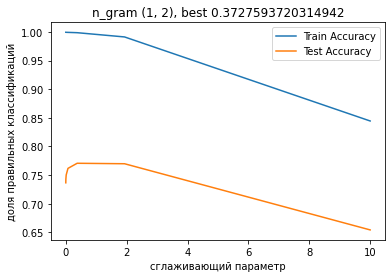

################################

 Наивный Байес: полиномиальная модель 

Time = 0.005019468127142415s

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1065
           1       0.79      0.79      0.79      1068

    accuracy                           0.79      2133
   macro avg       0.79      0.79      0.79      2133
weighted avg       0.79      0.79      0.79      2133



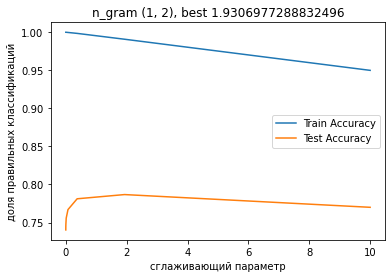

In [35]:
model_ngrams = [(1, 1), (2, 2), (1, 2)]
for i in model_ngrams:
    print('#'*32)
    print('\n K-ближайших соседей \n')
    k_neighbors(i)
    print('#'*32)
    print('\n Логистическая регрессия \n')
    logistic_regression(i)
    print('#'*32)
    print('\n Наивный Байес: модель Бернулли \n')
    model_bernulli(i)
    print('#'*32)
    print('\n Наивный Байес: полиномиальная модель \n')
    model_polynomial(i)

In [37]:
df_model

,Model,Class,N_gram,Model_param,Time_train,Time_prediction,Accuracy,Recall,Precision,F1
0,K-ближайших соседей,0,"(1, 1)",61,0.000831,0.669841,0.756681,0.719249,0.776876,0.746953
1,K-ближайших соседей,1,"(1, 1)",61,0.000831,0.669841,0.756681,0.794007,0.739320,0.765688
2,K-ближайших соседей,0,"(1, 1)",61,0.000826,0.656485,0.756681,0.719249,0.776876,0.746953
3,K-ближайших соседей,1,"(1, 1)",61,0.000826,0.656485,0.756681,0.794007,0.739320,0.765688
4,Логистическая регрессия,0,"(1, 1)",26.827,0.277453,0.000123,0.768870,0.763380,0.771347,0.767343
5,Логистическая регрессия,1,"(1, 1)",26.827,0.277453,0.000123,0.768870,0.774345,0.766450,0.770377
6,Наивный Байес: модель Бернулли,0,"(1, 1)",1.9307,0.002066,0.000742,0.725738,0.705164,0.734834,0.719693
7,Наивный Байес: модель Бернулли,1,"(1, 1)",1.9307,0.002066,0.000742,0.725738,0.746255,0.717372,0.731528
8,Наивный Байес: полиномиальная модель,0,"(1, 1)",1.9307,0.002364,0.000306,0.725738,0.705164,0.734834,0.719693
9,Наивный Байес: полиномиальная модель,1,"(1, 1)",1.9307,0.002364,0.000306,0.725738,0.746255,0.717372,0.731528
